In [1]:
from loading_augmenting_functions import add_labels_to_excel,gen_audio_array,buffer,shifter,louder,plot_mel,augment_audio,plot_sample,hsr_loader,lsr_loader,calc_stft,calc_melstft,spec_plot

In [2]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re

In [3]:
audio_path = 'zebra audio sample_Bing_413/all/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)

In [4]:
audio_files, audio_size, index_longest = gen_audio_array(audio_path,df)

In [5]:
augmented_audio = augment_audio(audio_files)

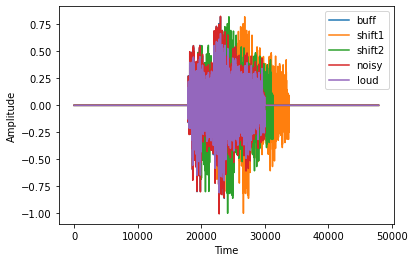

In [12]:
plot_sample(augmented_audio,100)

In [7]:
stfts = calc_stft(augmented_audio)

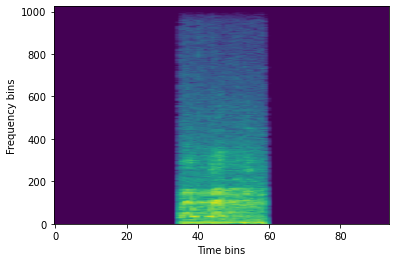

In [11]:
spec_plot(stfts[4,100,:,:])